#### Heap size error
- run this command line before run notebook

export PYSPARK_SUBMIT_ARGS='--driver-maxResultsSize 16g --driver-memory 16g --executor-memory 16g pyspark-shell'

In [1]:
# Configure MLflow Experiment
mlflow_experiment_id = 866112

# Including MLflow
import mlflow
import mlflow.spark
import os
print("MLflow Version: %s" % mlflow.__version__)

MLflow Version: 2.1.1


In [1]:
import pandas as pd
import numpy as np

### Source Data

In [2]:
#Data set is synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle
data_urls = "https://media.githubusercontent.com/media/FelixQLe/Detect_Financial_Fraud_at_Scale_with_decision_Trees/main/Synthetic_Financial_datasets_log.csv"

In [3]:
fin_fraud_dataset = pd.read_csv(data_urls, delimiter=',', header = 0)

In [4]:
#large dataset takes longer to load, so i make a copy to reuse in case
fin_fraud_copy = fin_fraud_dataset.copy()

In [5]:
fin_fraud_copy.shape

(6362620, 11)

### Create SQL database using PySpark

In [6]:
#import pyspark
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
print(f"PySpark Version : {pyspark.__version__}")

PySpark Version : 3.3.0


In [7]:
#Create a spark Context class
#sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
# Create spark builder session
#Create a spark Context class
sc = SparkContext()

23/02/04 22:23:14 WARN Utils: Your hostname, Hops-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.38 instead (on interface en0)
23/02/04 22:23:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/04 22:23:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/04 22:23:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [8]:
## Create spark session
spark = SparkSession.builder.master('local[6]').\
                config('saprk.sql.shuffle.partitions', 200).\
                config('spark.sql.debug.maxToStringFields', '100').\
                config('spark.default.parallelism', 300).\
                config('spark.driver.maxResultsSize', '15g').\
                config('spark.driver.memory', "32g").\
                config('spark.executor.memory','32g').\
                appName("Python Spark Dataframes Financial Fruad").getOrCreate()

In [9]:
fin_fraud_copy.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
#Loading data into Spark, take long
spark_df = spark.createDataFrame(fin_fraud_copy)

In [13]:
spark_df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)



In [12]:
spark_df.show()

23/02/04 22:26:42 WARN TaskSetManager: Stage 0 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/04 22:26:47 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997

In [14]:
#create table view fin_fraud_table, we can treat it as sql table
spark_df.createTempView("fin_fraud_table")

In [15]:
# Create df DataFrame which contains our simulated financial fraud detection dataset
fin_fraud_df = spark.sql("select step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest from fin_fraud_table")

In [16]:
fin_fraud_df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)



In [17]:
# Review the schema of your data 
fin_fraud_df.show()

23/02/04 22:57:58 WARN TaskSetManager: Stage 1 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/04 22:58:02 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|          

In [18]:
#add column orgDiff and destDiff based on the difference between Originating and Destination
fin_fraud_df = fin_fraud_df.withColumn("orgDiff",
                            fin_fraud_df.newbalanceOrig - 
                                       fin_fraud_df.oldbalanceOrg).withColumn("destDiff",
                            fin_fraud_df.newbalanceDest - fin_fraud_df.oldbalanceDest)
    
#create temporary view
fin_fraud_df.createOrReplaceTempView("financials")

In [19]:
fin_fraud_df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- orgDiff: double (nullable = true)
 |-- destDiff: double (nullable = true)



In [20]:
#review the new table
fin_fraud_df.show()

23/02/04 22:58:12 WARN TaskSetManager: Stage 2 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/04 22:58:16 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2 (TID 2): Attempting to kill Python Worker
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------------------+-------------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|            orgDiff|           destDiff|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------------------+-------------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0| -9839.640000000014|                0.0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|-1864.2799999999988|                0.0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|             

## Exploring Data Analysis

### What are the type of transactions?

In [21]:
%load_ext sparksql_magic

%config SparkSql.limit=20

In [22]:
%%sparksql
select type, count(1) from financials group by type

23/02/04 22:58:27 WARN TaskSetManager: Stage 3 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


type,count(1)
TRANSFER,532909
CASH_IN,1399284
CASH_OUT,2237500
PAYMENT,2151495
DEBIT,41432


##### plot the type of transactions

In [68]:
#collect type of transactions
type_transactions = 'select type, count(1) from financials group by type'
collected_data1 = spark.sql(type_transactions).collect()

23/02/04 23:41:08 WARN TaskSetManager: Stage 31 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [69]:
#convert to dataframe for plotting
df_trans_type = pd.DataFrame(collected_data1)
df_trans_type.rename(columns={0:'transactions', 1:'trans_total'}, inplace=True)

In [70]:
df_trans_type

,transactions,trans_total
0,TRANSFER,532909
1,CASH_IN,1399284
2,CASH_OUT,2237500
3,PAYMENT,2151495
4,DEBIT,41432


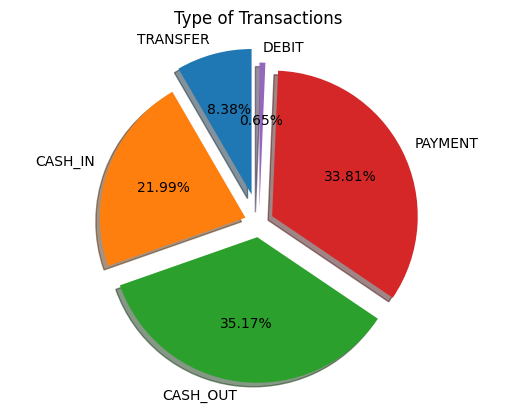

In [71]:
#plotting
import matplotlib.pyplot as plt
labels = df_trans_type.transactions
volume = df_trans_type.trans_total
explode = (0.2, 0.1, 0.1, 0.1, 0.1)
#pie
plt.pie(volume, labels=labels, startangle=90,
        shadow=True, explode=explode, autopct='%1.2f%%')
#title
plt.title('Type of Transactions')
plt.axis('equal')
plt.show()

### How much money each type of transactions made(synthetically)?

In [66]:
%%sparksql
SELECT type, SUM(amount) FROM financials GROUP BY type

23/02/04 23:38:21 WARN TaskSetManager: Stage 27 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


type,sum(amount)
TRANSFER,485291987263.16876
CASH_IN,236367391912.45996
CASH_OUT,394412995224.4904
PAYMENT,28093371138.37003
DEBIT,227199221.27999985


##### plot the the amount of money

In [76]:
#collect money data
total_money_each_type_trans = 'SELECT type, SUM(amount) FROM financials GROUP BY type'
collected_data2 = spark.sql(total_money_each_type_trans).collect()

23/02/04 23:44:28 WARN TaskSetManager: Stage 38 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [78]:
pd.DataFrame(collected_data2)

,0,1
0,TRANSFER,4.852920e+11
1,CASH_IN,2.363674e+11
2,CASH_OUT,3.944130e+11
3,PAYMENT,2.809337e+10
4,DEBIT,2.271992e+08


In [79]:
#convert to dataframe for plotting
df_total_money = pd.DataFrame(collected_data2)
df_total_money.rename(columns={0:'transactions', 1:'money_total'}, inplace=True)

In [80]:
df_total_money

,transactions,money_total
0,TRANSFER,4.852920e+11
1,CASH_IN,2.363674e+11
2,CASH_OUT,3.944130e+11
3,PAYMENT,2.809337e+10
4,DEBIT,2.271992e+08


In [85]:
df_trans_type.trans_total

0     532909
1    1399284
2    2237500
3    2151495
4      41432
Name: trans_total, dtype: int64

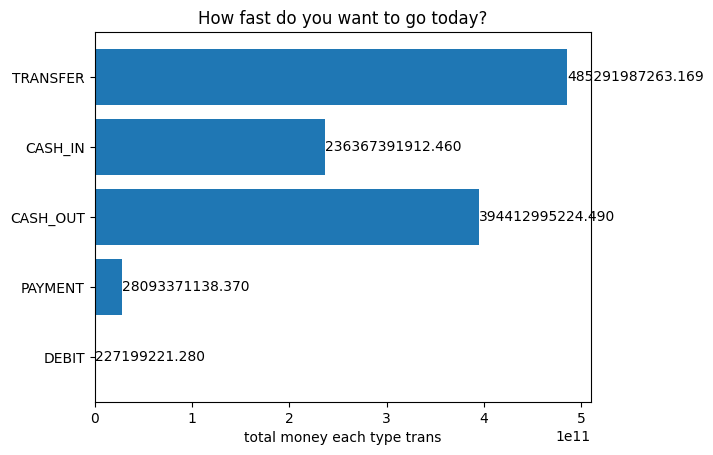

In [91]:
#plotting
import matplotlib.pyplot as plt
labels = df_total_money.transactions
y_pos = np.arange(len(labels))
volume = df_total_money.money_total

#bar chart
fig, ax = plt.subplots()

hbars = ax.barh(y_pos, volume, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()
ax.set_xlabel('total money each type trans')
ax.set_title('How fast do you want to go today?')

#Label with specially formatted floats
ax.bar_label(hbars, fmt='%.3f')
#ax.set_xlim(right=15) #adjust xlim to fit labels

plt.show()